In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
if IN_COLAB: 
    !pip install pandas
    !pip install numpy
    !pip install tensorflow
    !pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
if IN_COLAB:
  !nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-491f3281-4ff7-9543-bc22-f2a72d33e054)


In [ ]:
!pip freeze > requirements.txt

In [ ]:
if IN_COLAB:
  from google.colab import drive
  import sys
  drive.mount('/content/drive')
  sys.path.append('/content/drive/MyDrive')
  sys.path.append('/content/drive/MyDrive/swe-salary-predictor')

Mounted at /content/drive


In [ ]:
import time
import pandas as pd
from common import DataLoader
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format
sns.set_theme(color_codes=True)

In [ ]:
path = './data/stack-overflow-developer-survey-2021/survey_results_public.csv'
if IN_COLAB:
  path = './drive/MyDrive/swe-salary-predictor/survey_results_public.csv'

dl = DataLoader(path=path)
df = dl.df
df.head()

_start_pipeline:
  runtime=0:00:00.024849, end shape=(83439, 48)
_select:
  runtime=0:00:00.066231, end shape=(40627, 9)
_clean:
  runtime=0:00:00.166754, end shape=(40627, 9)
_remove_outliers:
  runtime=0:00:00.016151, end shape=(31610, 9)
_handle_missing:
  runtime=0:00:00.004997, end shape=(31610, 9)


,ConvertedCompYearly,EdLevel,Age1stCode,YearsCode,YearsCodePro,Country,DevType,LanguageHaveWorkedWith,Age
9,51552.00,Masters,14.00,7.00,4.00,Sweden,Data scientist or machine learning specialist,C++;Python,29.50
11,46482.00,Bachelors,14.00,12.00,5.00,Spain,"Developer, back-end",Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,29.50
12,77290.00,Masters,14.00,15.00,6.00,Germany,"Developer, desktop or enterprise applications;...",C;C++;Java;Perl;Ruby,29.50
16,17748.00,Bachelors,7.50,6.00,2.00,Turkey,"Developer, full-stack",C#;HTML/CSS;Java;JavaScript;Node.js,29.50
17,46135.00,Bachelors,14.00,9.00,6.00,Canada,"Developer, front-end;Developer, full-stack;Dev...",Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL,29.50


In [ ]:
df.isna().sum()

ConvertedCompYearly       0
EdLevel                   0
Age1stCode                0
YearsCode                 0
YearsCodePro              0
Country                   0
DevType                   0
LanguageHaveWorkedWith    0
Age                       0
dtype: int64

In [ ]:
# test out one hot encoding. get first USA row and see what it's encoded as
row = df.loc[df['Country'] == "United States of America"].iloc[0]
country_us = row["Country"]
country_us_encoded = dl.encodings["Country"].transform(pd.DataFrame(data={"Country": [country_us]}))
country_us_encoded

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0.]])

In [ ]:
# test linear regression on basic features
X = df[['YearsCode', 'YearsCodePro', 'Age1stCode', 'Age']]
y = df['ConvertedCompYearly']
linreg = LinearRegression()
print(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_absolute_error"))

[-37379.26620951 -37701.65807953 -35740.49314329 -38083.74939931
 -35831.83772192]


In [ ]:
# make transformer for one hot encoding and use in pipeline.
# this doesn't actually use DataLoader.encoding['Country'] - maybe that's not needed?
column_trans = make_column_transformer(
    (OneHotEncoder(), ["Country"]),
    remainder="passthrough")
X = df[['YearsCode', 'YearsCodePro', 'Age1stCode', 'Age', 'Country']]
column_trans.fit_transform(X)
pipe = make_pipeline(column_trans, linreg)
cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")

array([-25437.00581885, -24502.05812508, -22829.50685396, -25764.91445198,
       -24257.5998235 ])

# TODO
- Apply this pipeline/transformer to the keras model built below? And seperately use the transformer for making new inputs for predictions.
- Alternatively, extract df encoding tranformations logic out of `DataLoader.get_df()` so it can be applied to both the preprocessing of initial `df` and when we make inputs.

Alternative Linear Regression baseline


In [ ]:
# reg = LinearRegression()
# label = 'ConvertedCompYearly'
# labels = df[label]
# train = df.drop([label], axis=1)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state=1776)

In [ ]:
# # unencoded columns will raise exception: EdLevel, Country, DevType, LanguageHaveWorkedWith
# reg.fit(x_train, y_train)

In [ ]:
# def performance(x, y, name):
#     y_predict = reg.predict(x)
#     rmse = (np.sqrt(mean_squared_error(y, y_predict)))
#     r2 = r2_score(y, y_predict)

#     print(name)
#     print(f'  rmse={rmse}, r2={r2}')


# performance(x_train, y_train, 'train')
# performance(x_test, y_test, 'test')

In [ ]:
import tensorflow as tf
from tensorflow import keras

dl = DataLoader(path=path)
df = dl.df.drop(['EdLevel', 'Country', 'DevType','LanguageHaveWorkedWith'], axis=1)
print(df.head())

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('ConvertedCompYearly')
test_labels = test_features.pop('ConvertedCompYearly')
train_dataset.describe().transpose()[['mean', 'std']]

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('First example Normalized:', normalizer(first).numpy())

_start_pipeline:
  runtime=0:00:00.015474, end shape=(83439, 48)
_select:
  runtime=0:00:00.058466, end shape=(40627, 9)
_clean:
  runtime=0:00:00.188896, end shape=(40627, 9)
_remove_outliers:
  runtime=0:00:00.015446, end shape=(31610, 9)
_handle_missing:
  runtime=0:00:00.003634, end shape=(31610, 9)
    ConvertedCompYearly  Age1stCode  YearsCode  YearsCodePro   Age
9              51552.00       14.00       7.00          4.00 29.50
11             46482.00       14.00      12.00          5.00 29.50
12             77290.00       14.00      15.00          6.00 29.50
16             17748.00        7.50       6.00          2.00 29.50
17             46135.00       14.00       9.00          6.00 29.50
[[16.05023  15.330842  9.626164 33.570713]]
First example: [[21.  10.   5.  29.5]]

First example Normalized: [[ 0.72 -0.57 -0.59 -0.46]]


# Choosing the Right Loss Function

Why mean squared error? 
- gets rid of negatives, but this is also a feature of mean absolute error
- punishes large errors more

This is also what Chollete generally recommends for regression to arbitrary values (as opposed to 0 and 1) in Chapter 4 of "Deep Learning with Python."

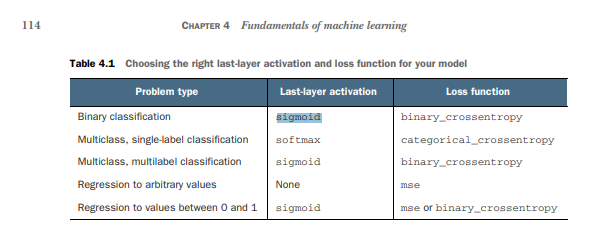

# Common Sense Baseline

Linear regression with single feature ('YearsCodePro')

In [ ]:
years_code_pro = np.array(train_features['YearsCodePro'])

ycp_normalizer = keras.layers.Normalization(input_shape=[1,], axis=None)
ycp_normalizer.adapt(years_code_pro)

In [ ]:
ycp_model = keras.Sequential([
    ycp_normalizer,
    keras.layers.Dense(1)
])
ycp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
ycp_model.predict(years_code_pro[:10])

array([[ 0.9721894 ],
       [ 0.7620392 ],
       [-2.8105142 ],
       [-0.07856162],
       [ 1.60264   ],
       [ 0.9721894 ],
       [ 1.1823397 ],
       [ 1.60264   ],
       [-2.1800637 ],
       [ 0.9721894 ]], dtype=float32)

In [ ]:
ycp_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error'
)

In [ ]:
%%time
ycp_history = ycp_model.fit(
    train_features['YearsCodePro'],
    train_labels,
    validation_split = 0.2,
    epochs=50,
    verbose=0)

MODELS = {
    "ycp": ycp_model.evaluate(test_features['YearsCodePro'], test_labels, verbose=0)
}

print(MODELS["ycp"])

8702258176.0
CPU times: user 1min 25s, sys: 14.6 s, total: 1min 39s
Wall time: 55.3 s


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

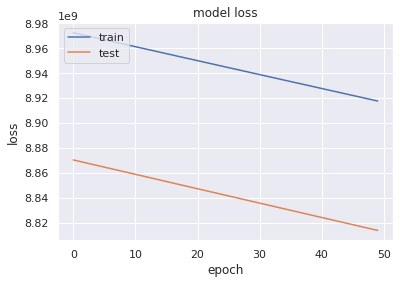

In [ ]:
plot_loss(ycp_history)

In [ ]:
ycp_hist_df = pd.DataFrame(ycp_history.history)
ycp_hist_df['epoch'] = ycp_history.epoch
ycp_hist_df.tail()

,loss,val_loss,epoch
45,8922126336.00,8818417664.00,45
46,8921009152.00,8817272832.00,46
47,8919898112.00,8816116736.00,47
48,8918775808.00,8814964736.00,48
49,8917660672.00,8813812736.00,49


Linear regression with more features (not encoded)



In [ ]:
lr_model = keras.Sequential([
    normalizer,
    keras.layers.Dense(1)
])
lr_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 14
Trainable params: 5
Non-trainable params: 9
_________________________________________________________________


In [ ]:
lr_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    # loss='mean_squared_error'
    loss='mean_absolute_error'
)

In [ ]:
%%time
lr_history = lr_model.fit(
    train_features,
    train_labels,
    validation_split = 0.2,
    epochs=50,
    verbose=0)

MODELS = {
    "lr": lr_model.evaluate(test_features, test_labels, verbose=0)
}

print(MODELS["lr"])

78428.9140625
CPU times: user 1min 26s, sys: 14.6 s, total: 1min 40s
Wall time: 55.9 s


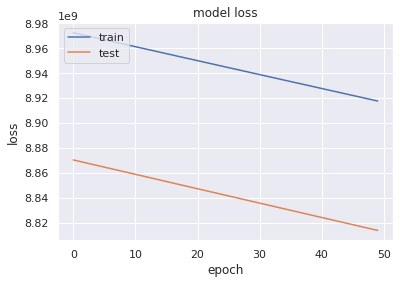

In [ ]:
plot_loss(ycp_history)

In [ ]:
def build_model():
  model = keras.Sequential([
      normalizer,
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                # loss='mean_squared_error',
                loss='mean_absolute_error')
  return model

dnn1_model = build_model()
print(dnn1_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                320       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


In [ ]:
  %%time
  history1 = dnn1_model.fit(
      train_features,
      train_labels,
      validation_split=0.2, 
      epochs=50)
  
  MODELS['dnn1'] = dnn1_model.evaluate(test_features, test_labels, verbose=0)

  print(MODELS['dnn1'])

Epoch 1/50
633/633 [==============================] - 2s 2ms/step - loss: 77543.0859 - val_loss: 72139.7109
Epoch 2/50
633/633 [==============================] - 1s 2ms/step - loss: 58783.0273 - val_loss: 45765.0625
Epoch 3/50
633/633 [==============================] - 1s 2ms/step - loss: 42238.0625 - val_loss: 40420.8672
Epoch 4/50
633/633 [==============================] - 1s 2ms/step - loss: 39270.1641 - val_loss: 38633.0469
Epoch 5/50
633/633 [==============================] - 1s 2ms/step - loss: 37678.8711 - val_loss: 37399.7227
Epoch 6/50
633/633 [==============================] - 1s 2ms/step - loss: 36657.0156 - val_loss: 36654.6836
Epoch 7/50
633/633 [==============================] - 1s 2ms/step - loss: 36082.7344 - val_loss: 36214.1367
Epoch 8/50
633/633 [==============================] - 1s 2ms/step - loss: 35779.0625 - val_loss: 35953.0469
Epoch 9/50
633/633 [==============================] - 2s 2ms/step - loss: 35624.2266 - val_loss: 35831.8867
Epoch 10/50
633/633 [=======

# Validating our approach

Finding the ideal number of epochs

In [ ]:
print(history1.history.keys())

dict_keys(['loss', 'val_loss'])


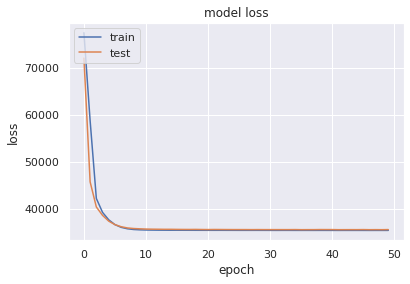

In [ ]:
plot_loss(history1)

Now we can redefine the `build_model` function. It now takes a `hp` parameter which will be used to make hyper parameters for the number of units in a layer (ranging from 32 to 256 with a step of 32) and the number of layers to add.

In [ ]:
def build_model(hp):
  model = keras.Sequential() # might need to be keras.models.Sequential() ??

  model.add(normalizer)
  model.add(keras.layers.Dense(hp.Int("units", min_value=32, max_value=256, step=32), activation='relu'))

  for i in range(hp.Int("n_layers", min_value=1, max_value=4)):
    model.add(keras.layers.Dense(hp.Int(f"units-{i}", min_value=32, max_value=256, step=32), activation='relu'))

  model.add(keras.layers.Dense(1))

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
      # loss='mean_squared_error'
      loss='mean_absolute_error')
  return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective = "val_loss",
    max_trials = 3,
    executions_per_trial = 1,
    # directory = f'${int(time.time())}'
)

In [ ]:
tuner.search(x=train_features,
             y=train_labels,
             epochs=10,
             batch_size=64,
             validation_data=(test_features, test_labels))

Trial 3 Complete [00h 00m 21s]
val_loss: 34791.80859375

Best val_loss So Far: 34791.80859375
Total elapsed time: 00h 00m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(tuner.get_best_hyperparameters()[0].values)

{'units': 224, 'n_layers': 4, 'units-0': 192, 'units-1': 224, 'units-2': 160, 'units-3': 32}


In [ ]:
print(tuner.results_summary())

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 224
n_layers: 4
units-0: 192
units-1: 224
units-2: 160
units-3: 32
Score: 34791.80859375
Trial summary
Hyperparameters:
units: 224
n_layers: 3
units-0: 32
units-1: 32
units-2: 32
Score: 35006.18359375
Trial summary
Hyperparameters:
units: 160
n_layers: 1
units-0: 224
Score: 35074.5078125
None


Now we can get the best model from our tuner using the `get_best_model` method.

In [ ]:
best_model = tuner.get_best_models()[0]
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 224)               1120      
                                                                 
 dense_1 (Dense)             (None, 192)               43200     
                                                                 
 dense_2 (Dense)             (None, 224)               43232     
                                                                 
 dense_3 (Dense)             (None, 160)               36000     
                                                                 
 dense_4 (Dense)             (None, 32)                5152      
                                                        

Now we can fit our data to the `best_model` and compare with the results from our preliminary model (before hyperparameter tuning).

In [ ]:
  %%time
  history_best = best_model.fit(
      train_features,
      train_labels,
      validation_split=0.2, 
      epochs=25)
  
  MODELS['best'] = best_model.evaluate(test_features, test_labels, verbose=0)

  print(MODELS['best'])

Epoch 1/25
633/633 [==============================] - 2s 3ms/step - loss: 35444.0742 - val_loss: 35467.6719
Epoch 2/25
633/633 [==============================] - 2s 3ms/step - loss: 35422.6172 - val_loss: 35418.1211
Epoch 3/25
633/633 [==============================] - 2s 3ms/step - loss: 35406.4102 - val_loss: 35438.8867
Epoch 4/25
633/633 [==============================] - 2s 3ms/step - loss: 35419.6484 - val_loss: 35408.8203
Epoch 5/25
633/633 [==============================] - 2s 3ms/step - loss: 35414.3711 - val_loss: 35581.0195
Epoch 6/25
633/633 [==============================] - 2s 3ms/step - loss: 35377.6992 - val_loss: 35677.2812
Epoch 7/25
633/633 [==============================] - 2s 3ms/step - loss: 35431.7617 - val_loss: 35457.8555
Epoch 8/25
633/633 [==============================] - 2s 3ms/step - loss: 35418.5000 - val_loss: 35426.0508
Epoch 9/25
633/633 [==============================] - 2s 3ms/step - loss: 35366.3438 - val_loss: 35624.8398
Epoch 10/25
633/633 [=======

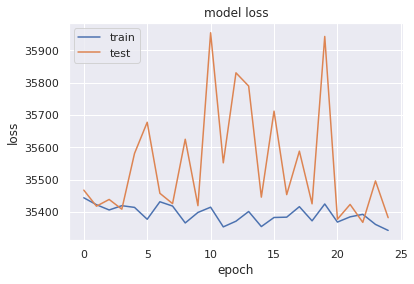

In [ ]:
plot_loss(history_best)

In [ ]:
# # make prediction and compare to baseline - is it way off?

# # RAW_DATASET_LABELS = ["ResponseId","MainBranch","Employment","Country","US_State","UK_Country","EdLevel","Age1stCode","LearnCode","YearsCode","YearsCodePro","DevType","OrgSize","Currency","CompTotal","CompFreq","LanguageHaveWorkedWith","LanguageWantToWorkWith","DatabaseHaveWorkedWith","DatabaseWantToWorkWith","PlatformHaveWorkedWith","PlatformWantToWorkWith","WebframeHaveWorkedWith","WebframeWantToWorkWith","MiscTechHaveWorkedWith","MiscTechWantToWorkWith","ToolsTechHaveWorkedWith","ToolsTechWantToWorkWith","NEWCollabToolsHaveWorkedWith","NEWCollabToolsWantToWorkWith","OpSys","NEWStuck","NEWSOSites","SOVisitFreq","SOAccount","SOPartFreq","SOComm","NEWOtherComms","Age","Gender","Trans","Sexuality","Ethnicity","Accessibility","MentalHealth","SurveyLength","SurveyEase","ConvertedCompYearly"]

# def make_prediction_input(input_map):
#     # required keys in inputMap: 
#     #   "YearsCode", "YearsCodePro", "Country", "Age1stCode", "EdLevel", "Age"

#     defaults = {
#         'ConvertedCompYearly': DataLoader.salary_min + 1, # any value that doesn't get filtered out
#         'Employment': 'Employed full-time', # must be full time
#         'DevType': None,
#         'LanguageHaveWorkedWith': None
#     }
    
#     for key in defaults.keys():
#         if key not in input_map:
#             input_map[key] = defaults[key]

#     df = pd.DataFrame.from_records([input_map])
#     dl = DataLoader(df=df)
#     # df_input = dl.df[["YearsCode", "YearsCodePro"]]

#     print(df_input.head())
#     row = df_input.iloc(0)[0]
#     return list(row)

# prediction_input = make_prediction_input({
#     "YearsCode": 1,
#     "YearsCodePro": 2,
#     "Country": "United States of America",
#     "Age1stCode": 16,
#     "EdLevel": "Bachelors",
#     "Age": 30,
# })
# print(prediction_input)

In [ ]:
dl.encodings

{'Country': OneHotEncoder(sparse=False)}

# Predict

In [ ]:
# should not need to be normalized for predicting.
# country should be OHE, else  OHE should be in model layer
pred_input = np.array([1, 1, 1, 1])
pred = best_model.predict(pred_input)[:, 0]
pred[0]

26655.191

# Make model using encoded features

In [ ]:
def transform_df_ohe_country(df):
  # returns df with countries as columns of 0 or 1

  # encode
  ohe = OneHotEncoder(categories = "auto")
  feature_arr = ohe.fit_transform(df[['Country']]).toarray()
  # merge encoded into df
  df = merge_ohe(df, ohe, feature_arr)
  # drop country
  df = df.drop(['Country'], axis=1)
  
  return df, ohe

def merge_ohe(df, ohe, feature_arr):
  feature_labels = np.array(ohe.categories_).ravel()
  df_features = pd.DataFrame(feature_arr, columns=feature_labels)
  df.reset_index(drop=True, inplace=True)
  df_features.reset_index(drop=True, inplace=True)
  df = pd.concat([df, df_features], axis=1)
  return df

def transform_df_mlb_delimited_string(df, column):
  # change delimited string to list
  df[column] = df[column].apply(lambda x: x.split(';'))

  mlb = MultiLabelBinarizer()
  encoded = mlb.fit_transform(df.pop(column))

  df = merge_mlb(df, mlb, encoded)
  
  return df, mlb
  
def merge_mlb(df, mlb, encoded):
  return df.join(pd.DataFrame(encoded, columns=mlb.classes_, index=df.index))  

def transform_df_oe(df):
  oe = OrdinalEncoder(categories=[['Less than Associates', 'Associates', 
                                   'Bachelors', 'Masters', 'Doctorate']])
  df['EdLevel'] = oe.fit_transform(df['EdLevel'].values.reshape(-1,1))
  return df, oe



In [ ]:
import pickle

df = dl.df
df, country_ohe = transform_df_ohe_country(df)
df, dev_type_mlb = transform_df_mlb_delimited_string(df, 'DevType')
df, languages_mlb = transform_df_mlb_delimited_string(df, 'LanguageHaveWorkedWith')
df, ed_level_oe = transform_df_oe(df)

encodings = {
  "country_ohe": country_ohe,
  "dev_type_mlb": dev_type_mlb,
  "languages_mlb": languages_mlb,
  "ed_level_oe": ed_level_oe
}

# save ohe
with open("encodings.pickle", "wb") as f: 
    pickle.dump(encodings, f)

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('ConvertedCompYearly')
test_labels = test_features.pop('ConvertedCompYearly')

train_features.head()

# train_dataset.describe().transpose()[['mean', 'std']]

# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(np.array(train_features))
# print(normalizer.mean.numpy())

# first = np.array(train_features[:1])

# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('First example Normalized:', normalizer(first).numpy())

,EdLevel,Age1stCode,YearsCode,YearsCodePro,Age,Argentina,Australia,Austria,Belgium,Brazil,...,PowerShell,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA
21426,3.00,21.00,10.00,5.00,29.50,0.00,0.00,0.00,0.00,0.00,...,0,0,0,1,0,1,0,0,0,0
18,2.00,21.00,12.00,6.00,29.50,0.00,0.00,0.00,0.00,0.00,...,1,0,0,0,0,0,0,0,1,1
18438,3.00,14.00,26.00,23.00,39.50,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0
18322,3.00,14.00,25.00,10.00,39.50,0.00,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0,0,0,0
13802,3.00,14.00,9.00,2.00,29.50,0.00,0.00,0.00,1.00,0.00,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
list(df.columns)

['ConvertedCompYearly',
 'EdLevel',
 'Age1stCode',
 'YearsCode',
 'YearsCodePro',
 'Age',
 'Argentina',
 'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Bulgaria',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Croatia',
 'Czech Republic',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'India',
 'Iran, Islamic Republic of...',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Lithuania',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Russian Federation',
 'Serbia',
 'Singapore',
 'Slovenia',
 'South Africa',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Turkey',
 'Ukraine',
 'United Kingdom of Great Britain and Northern Ireland',
 'United States of America',
 'Academic researcher',
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 'Database administrator',
 'Designer',
 'DevOps specialist',
 'Developer, QA or test',
 'Developer, back-end',
 'Developer, desktop or enterprise applications',

In [ ]:
def build_model(hp):
  model = keras.Sequential()
  
  # model.add(normalizer)
  # model.add(keras.Input(shape=(None, 49))) # this might not be right...
  model.add(keras.layers.Dense(hp.Int("units", min_value=32, max_value=256, step=32), activation='relu'))

  for i in range(hp.Int("n_layers", min_value=1, max_value=4)):
    model.add(keras.layers.Dense(hp.Int(f"units-{i}", min_value=32, max_value=256, step=32), activation='relu'))

  model.add(keras.layers.Dense(1))

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
      # loss='mean_squared_error'
      loss='mean_absolute_error')
  return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective = "val_loss",
    max_trials = 3,
    executions_per_trial = 1,
    directory = f'${int(time.time())}'
)

In [ ]:
tuner.search(x=train_features,
             y=train_labels,
             epochs=10,
             batch_size=64,
             validation_data=(test_features, test_labels))

Trial 3 Complete [00h 00m 10s]
val_loss: 21474.90625

Best val_loss So Far: 21150.19921875
Total elapsed time: 00h 00m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())

{'units': 96, 'n_layers': 3, 'units-0': 224, 'units-1': 128, 'units-2': 256}
Results summary
Results in $1656040999/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 96
n_layers: 3
units-0: 224
units-1: 128
units-2: 256
Score: 21150.19921875
Trial summary
Hyperparameters:
units: 256
n_layers: 2
units-0: 192
units-1: 224
units-2: 256
Score: 21474.90625
Trial summary
Hyperparameters:
units: 224
n_layers: 3
units-0: 128
units-1: 32
units-2: 32
Score: 21477.955078125
None


In [ ]:
test_features.values

array([[ 2. , 28.5,  4. , ...,  0. ,  0. ,  0. ],
       [ 2. , 14. ,  8. , ...,  0. ,  0. ,  0. ],
       [ 3. ,  7.5, 34. , ...,  0. ,  1. ,  0. ],
       ...,
       [ 3. ,  7.5, 30. , ...,  0. ,  1. ,  0. ],
       [ 3. ,  7.5, 16. , ...,  0. ,  1. ,  0. ],
       [ 2. , 14. , 17. , ...,  0. ,  0. ,  0. ]])

In [ ]:
best_model = tuner.get_best_models()[0]
# best_model.build(test_features.values) # maybe do this instead of the Input "layer" in build model
# print(best_model.summary())

In [ ]:
  %%time
  history_best = best_model.fit(
      train_features,
      train_labels,
      validation_split=0.2, 
      epochs=150)
  
  MODELS['best'] = best_model.evaluate(test_features, test_labels, verbose=0)

  print(MODELS['best'])

Epoch 1/150
633/633 [==============================] - 2s 3ms/step - loss: 21119.6875 - val_loss: 21111.0762
Epoch 2/150
633/633 [==============================] - 2s 3ms/step - loss: 20953.6562 - val_loss: 21021.2266
Epoch 3/150
633/633 [==============================] - 2s 2ms/step - loss: 20901.1426 - val_loss: 20709.7480
Epoch 4/150
633/633 [==============================] - 2s 2ms/step - loss: 20864.6445 - val_loss: 20711.5820
Epoch 5/150
633/633 [==============================] - 2s 2ms/step - loss: 20825.1758 - val_loss: 20664.8105
Epoch 6/150
633/633 [==============================] - 2s 2ms/step - loss: 20786.2832 - val_loss: 20723.0723
Epoch 7/150
633/633 [==============================] - 2s 2ms/step - loss: 20762.3711 - val_loss: 21065.1602
Epoch 8/150
633/633 [==============================] - 2s 2ms/step - loss: 20727.2871 - val_loss: 21058.0215
Epoch 9/150
633/633 [==============================] - 2s 2ms/step - loss: 20513.0566 - val_loss: 20572.5117
Epoch 10/150
633/63

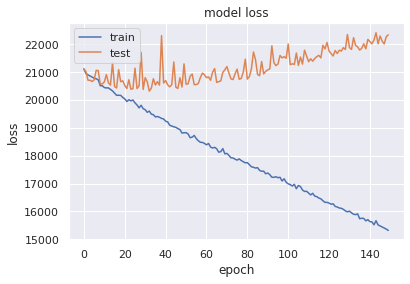

In [ ]:
plot_loss(history_best)

In [ ]:
# # should not need to be normalized for predicting.
# # country should be OHE, else  OHE should be in model layer
def make_input(input_dict):
  df_input = pd.DataFrame(data={
      "EdLevel": [input_dict["ed_level"]], # will be transformed inplace below when encoded
      "Age1stCode": [input_dict["age_first_code"]],
      "YearsCode": [input_dict["years_code"]],
      "YearsCodePro": [input_dict["years_code_pro"]],
      "Age": [input_dict["age"]],
  })
  # encode Country
  country_enc = country_ohe.transform(pd.DataFrame(
      data={"Country": [input_dict["country"]]})).toarray()
  df = merge_ohe(df_input, country_ohe, country_enc)
  
  # encode Devtype
  dev_type_enc = dev_type_mlb.transform(pd.Series([input_dict["dev_type"]]))
  df = merge_mlb(df, dev_type_mlb, dev_type_enc)

  # encode LanguageHaveWorkedWith
  languages_enc = languages_mlb.transform(pd.Series([input_dict["languages"]]))
  df = merge_mlb(df, languages_mlb, languages_enc)

  # encode Edlevel
  df['EdLevel'] = ed_level_oe.transform(df['EdLevel'].values.reshape(-1,1))

  return df.values

pred_input = make_input({"age_first_code": 16, "years_code": 4,
                         "years_code_pro": 3, "age": 33, 
                         "country": "United States of America", 
                         "dev_type": ["Developer, full-stack"],
                         "languages": ["Python", "JavaScript", "SQL"],
                         "ed_level": "Bachelors"})
pred_input

array([[ 2., 16.,  4.,  3., 33.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [ ]:
pred = best_model.predict(pred_input)[:, 0]
pred[0]

93744.63

In [ ]:
filename = f'./model_{int(time.time())}'
keras.models.save_model(best_model, filename)

INFO:tensorflow:Assets written to: ./model_1656041268/assets


In [ ]:
saved_model = tf.keras.models.load_model('./model_1656041268')

In [ ]:
saved_model.predict(pred_input)[0][0]

93744.63